In [2]:
import yfinance as yf
sp500 = yf.download("^GSPC")

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

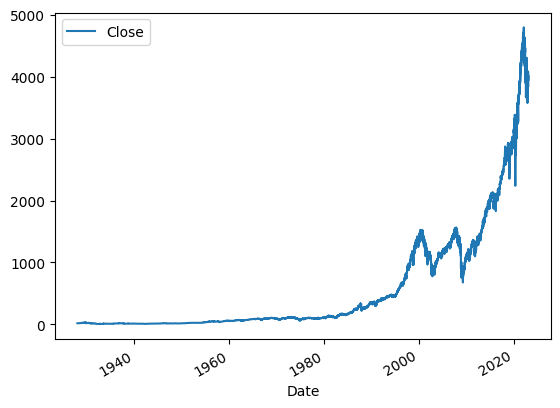

In [3]:
#Overview of stock
sp500.plot.line(y="Close", use_index =True)

In [4]:
#Make sure not using current data for predictions
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [5]:
#Use recent data
sp500 = sp500.loc["1990-01-01":].copy()

In [6]:
#Training the model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Open", "Volume", "High", "Low"]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [7]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])

#Turn array into pandas series
import pandas as pd
preds = pd.Series(preds, index=test.index)

#Accuracy
precision_score(test["Target"], preds)

0.3974358974358974

<AxesSubplot: xlabel='Date'>

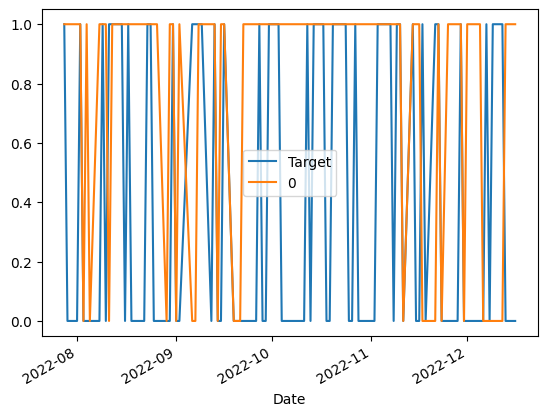

In [8]:
#Visualize predictions
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()


In [9]:
#Model prediction function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"],preds], axis=1)
    return combined

In [10]:
#Back testing the model
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [11]:
predictions = backtest(sp500, model, predictors)

In [12]:
#How many times is each prediction type is made
predictions["Predictions"].value_counts()

0    3349
1    2457
Name: Predictions, dtype: int64

In [13]:
#Accuracy of model
precision_score(predictions["Target"], predictions["Predictions"])

0.5266585266585266

In [14]:
#% of stocks actually went up and down
predictions["Target"].value_counts()/ predictions.shape[0]

1    0.534103
0    0.465897
Name: Target, dtype: float64

In [15]:
#Add indicators showing price move in different time frames
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"]/ rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

new_predictors += [ratio_column, trend_column]

In [16]:
#Clean NA data
sp500= sp500.dropna()

In [17]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [18]:
#Model prediction function improvements, less trades that are more accurate
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"],preds], axis=1)
    return combined

In [19]:
predictions = backtest(sp500, model, new_predictors)

In [20]:
predictions["Predictions"].value_counts()

0.0    3521
1.0    1284
Name: Predictions, dtype: int64

In [21]:
#Improved accuracy
precision_score(predictions["Target"], predictions["Predictions"])

0.5023364485981309